In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot  as plt
from collections import Counter
from umls_utils import get_paths, CUIbase64

pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')

In /Users/stearb/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/stearb/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/stearb/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/stearb/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/stearb/opt/anaconda3/lib/pytho

In [10]:
!jupyter nbconvert --to script IMPC_ftp-Copy1.ipynb
!sed -i '' '/.head(/d' IMPC_ftp-Copy1.py
!sed -i '' '/^#/d' IMPC_ftp-Copy1.py
!sed -i '' '/get_ipython()/d' IMPC_ftp-Copy1.py
!sed -i '' '/print/d' IMPC_ftp-Copy1.py

[NbConvertApp] Converting notebook IMPC_ftp-Copy1.ipynb to script
[NbConvertApp] Writing 26156 bytes to IMPC_ftp-Copy1.py


In [4]:
# Get paths from config file

config_path = '/Users/stearb/Dropbox/CHOP/R03/code/neo4j_build_CFDIKG/build_scripts/'
data_dir,helper_data_dir,output_dir,LOCAL_CPU, umls_dir, umls_out_dir = get_paths('/Users/stearb/Dropbox/CHOP/R03/code/neo4j_build_CFDIKG/build_scripts/')

if not  os.path.isdir(output_dir+'genopheno'):
    os.mkdir(output_dir+'genopheno')
    print('Creating genopheno directory...')

# Main notebook for IMPC data cleaning

### Input files:
    * IMPC
        - genotype-phenotype-assertions-ALL.csv
        - statistical-results-ALL.csv
    * MGI
        - MGI_PhenoGenoMP.rpt (Table 5)
        - mgi_master_geno2pheno.csv

### Output  files:
    * UMLS-KF
        - CUI-CUI.csv
        - CODEs.csv

# IPMC README.txt
http://ftp.ebi.ac.uk/pub/databases/impc/all-data-releases/latest/results/README.txt

## Download and clean genotype-phenotype data from IMPC
### First look at just the genotype-phenotype-assertions-ALL.csv file

In [5]:
gno_phno = data_dir+'genotype-phenotype-assertions-ALL.csv'


cols_to_drop = ['phenotyping_center','colony_id','sex','zygosity','strain_name','project_name',
                'project_fullname','pipeline_name','pipeline_stable_id','procedure_stable_id',
                'parameter_stable_id','p_value','percentage_change','effect_size','statistical_method',
                   'resource_name','strain_accession_id','allele_name','procedure_name','marker_accession_id',
               'allele_symbol']

df=pd.read_csv(gno_phno).drop(cols_to_drop,axis=1)

print(df.shape)
df.head(3)

(60174, 7)


,marker_symbol,allele_accession_id,parameter_name,top_level_mp_term_id,top_level_mp_term_name,mp_term_id,mp_term_name
0,Gimap3,MGI:5883410,Cornea,MP:0005391,vision/eye phenotype,MP:0001312,abnormal cornea morphology
1,Prss8,MGI:5646004,Embryo Size,"MP:0005380,MP:0005378","embryo phenotype,growth/size/body region pheno...",MP:0001697,abnormal embryo size
2,Pstpip2,MGI:5755044,Seminal vesicle,"MP:0005389,MP:0005379","reproductive system phenotype,endocrine/exocri...",MP:0002059,abnormal seminal vesicle morphology


In [4]:
# Show number of unique values in each column
df.nunique().to_frame().T

,marker_symbol,allele_accession_id,parameter_name,top_level_mp_term_id,top_level_mp_term_name,mp_term_id,mp_term_name
0,6007,6235,972,59,59,746,746


In [5]:
# How many nulls in each col?
df.isna().sum()

marker_symbol                2
allele_accession_id          2
parameter_name               0
top_level_mp_term_id      1150
top_level_mp_term_name    1150
mp_term_id                 877
mp_term_name               877
dtype: int64

In [6]:
rows_w_na = df.shape[0]
df.dropna(inplace=True)
print(f'Dropped {rows_w_na-df.shape[0]} rows after getting rid of Nan')

Dropped 1150 rows after getting rid of Nan


In [2]:
# Save to check consistency later
#df[['marker_symbol','parameter_name',
#    'allele_accession_id','mp_term_id',
#    'mp_term_name','top_level_mp_term_id']].to_csv(
#    '/Users/stearb/desktop/R03_local/data/ingest_files/genopheno/geno2pheno_mapping.csv')

In [8]:
df_dropdup = df.drop_duplicates(['marker_symbol','mp_term_id','mp_term_name','allele_accession_id','parameter_name'])
df_dropdup.shape

(36671, 7)

In [9]:
# Seperate the 'top_level_mp_term_id'  column by '|'
all_top_level_mp_terms = np.ravel(list(df['top_level_mp_term_id'].apply(lambda x: x.split('|')).values))

# Split results by ','
all_top_level_mp_terms_ = list([i.split(',') for i in all_top_level_mp_terms])

# Flatten it.
flat_list = [item for sublist in all_top_level_mp_terms_ for item in sublist]

print('There are '+str(len(np.unique(flat_list))) + ' unique top level MP terms in this dataset.')

There are 24 unique top level MP terms in this dataset.


In [10]:
print('There are '+str(len(df['mp_term_id'].unique()))+' unique MP terms in this dataset.')

There are 740 unique MP terms in this dataset.


In [11]:
print('There are '+str(df['marker_symbol'].unique().shape[0])+' unique genes in this dataset.')

There are 5966 unique genes in this dataset.


## Now look at another IMPC file called statistical-results-ALL.csv file

In [12]:
# This is a larger file, slighlty over 1 GB

#stats = pd.read_csv(data_dir+'statistical-results-ALL.csv')
stats = pd.read_pickle(data_dir+'statistical-results-ALL.pickle')

#list(stats.columns)  # See all available columns,  there are 87 columns

# Just select the most important columns right now.
stats_cols_to_include = ['marker_symbol','parameter_name','allele_name','marker_accession_id',
                         'mp_term_id','mp_term_name','top_level_mp_term_id','top_level_mp_term_name',
                         'allele_symbol','allele_accession_id']

stats_slct = stats[stats_cols_to_include]

print(stats.shape)
stats_slct.head(3) 

(1905809, 87)


,marker_symbol,parameter_name,allele_name,marker_accession_id,mp_term_id,mp_term_name,top_level_mp_term_id,top_level_mp_term_name,allele_symbol,allele_accession_id
0,Gpank1,Skeletal muscle,tm1.1(KOMP)Vlcg,MGI:2148975,NaN,NaN,NaN,NaN,Gpank1<tm1.1(KOMP)Vlcg>,MGI:5574607
1,Prrc2c,Tail Morphology,em1(IMPC)J,MGI:1913754,NaN,NaN,MP:0005371,limbs/digits/tail phenotype,Prrc2c<em1(IMPC)J>,MGI:6143826
2,Adh5,Thyroid,tm1b(EUCOMM)Wtsi,MGI:87929,NaN,NaN,NaN,NaN,Adh5<tm1b(EUCOMM)Wtsi>,MGI:5548916


In [13]:
# How many nans per column?
stats_slct.isna().sum().to_frame().T

,marker_symbol,parameter_name,allele_name,marker_accession_id,mp_term_id,mp_term_name,top_level_mp_term_id,top_level_mp_term_name,allele_symbol,allele_accession_id
0,1,0,42155,1,1871375,1871376,770079,770079,1,1


In [14]:
stats_slct.dropna(inplace=True) 
print(stats_slct.shape)
stats_slct.head(3)

(33157, 10)


,marker_symbol,parameter_name,allele_name,marker_accession_id,mp_term_id,mp_term_name,top_level_mp_term_id,top_level_mp_term_name,allele_symbol,allele_accession_id
23,Cd3eap,Limb Plate Morphology,tm1b(KOMP)Wtsi,MGI:1917583,MP:0004576,abnormal embryonic autopod plate morphology,MP:0005371,limbs/digits/tail phenotype,Cd3eap<tm1b(KOMP)Wtsi>,MGI:5692700
73,Pxdn,Whole arena average speed,em1(IMPC)J,MGI:1916925,MP:0003313,abnormal locomotor activation,MP:0005386,behavior/neurological phenotype,Pxdn<em1(IMPC)J>,MGI:5829376
110,Mkrn3,Fasted blood glucose concentration,em1(IMPC)Tcp,MGI:2181178,MP:0013277,abnormal fasting circulating glucose level,MP:0005376,homeostasis/metabolism phenotype,Mkrn3<em1(IMPC)Tcp>,MGI:6156558


In [15]:
# There are only 694 unique MP terms in the statistical-results-ALL.csv dataset.
stats_slct['mp_term_id'].unique().shape

(694,)

In [16]:
# Lets see the most common MP terms in this dataset.
Counter(stats_slct['mp_term_id'].values).most_common(5)

[('MP:0003313', 2014),
 ('MP:0011100', 1790),
 ('MP:0001515', 698),
 ('MP:0011110', 663),
 ('MP:0001697', 651)]

In [17]:
# Top 3 most common MP terms
print(stats_slct[stats_slct['mp_term_id'] == 'MP:0003313']['mp_term_name'].unique()[0])
print(stats_slct[stats_slct['mp_term_id'] == 'MP:0011100']['mp_term_name'].unique()[0])
print(stats_slct[stats_slct['mp_term_id'] == 'MP:0001515']['mp_term_name'].unique()[0])

abnormal locomotor activation
preweaning lethality, complete penetrance
abnormal grip strength


In [18]:
########## Can exclude the following code in the .py script ###########

## Now lets compare the first genotype-phenotype IMPC dataset we looked at 
# (genotype-phenotype-assertions-ALL.csv) with genotype-phenotype datasets from 
# MGI from http://www.informatics.jax.org/downloads/reports/index.html#pheno
# Lets look at the MGI Table 5 Dataset 
### All Genotypes and Mammalian Phenotype Annotations (tab-delimited)

#if LOCAL_CPU: mgi_table5_extracted_geno_pheno_data = '/Users/stearb/dropbox/CHOP/R03/code/genotype_phenotype/geno2pheno_MGI_table5.csv'
#else: mgi_table5_extracted_geno_pheno_data = data_dir+'geno2pheno_MGI_table5.csv'


#mgi5 =pd.read_csv(mgi_table5_extracted_geno_pheno_data,sep='\t',index_col=0)
#print(mgi5.shape)
#mgi5.head(3)  

### Lets see the overlap in MP terms 
#### All of  the MP terms in the genotype-phenotype-assertions-ALL IMPC dataset are in the MGI Table 5 dataset.

#print('Total unique MP terms in IMPC dataset: ' + str(len(df['mp_term_id'].unique())))
#print('Total unique MP terms in MGI Table 5 dataset: ' + str(len(mgi5['Mammalian Phenotype ID'].unique())))
#o = len(set(mgi5['Mammalian Phenotype ID']).intersection(set(df['mp_term_id'])))
#print(f'Overlap in MP terms between the 2 datasets: {o}')


#### Side Note: Most (97%; 5825/5966) of the genes in both datasets overlap, so we still might want to include data set in the master phenotype to genotype list to get those 3% of genes. 
#print('There are '+str(df['marker_symbol'].unique().shape[0])+' unique genes in the IMPC dataset.')
#print('There are '+str(mgi5['Gene'].unique().shape[0])+ ' unique genes in the  MGI Table 5 dataset.')
#g = len(set(mgi5['Gene']).intersection(set(df['marker_symbol'])))
#print(f'Overlap in genes between the 2 datasets: {g}')


### So, by including the MGI Table 5 dataset, we increase the number of MP terms (that are mapped to at least one gene) from 740 to 10,525. Lets see if there is more overlap between these MP terms and the MP terms that were cross-linked from HPO by Tiffany. This is where the bottleneck in the graph was when we were using just the 740 MP terms from the IMPC dataset.
#if LOCAL_CPU: hpo2mp = pd.read_csv('/Users/stearb/dropbox/CHOP/R03/code/phenotype_mapping/tiffs_mappings_ravel.csv',index_col=0)
#else: hpo2mp = pd.read_csv(helper_data_dir+'tiffs_mappings_ravel.csv',index_col=0)

    
#print(hpo2mp.shape)
#hpo2mp.head(3)

#len(set(hpo2mp['MPO_URI'].unique()).intersection(set(mgi5['Mammalian Phenotype ID'].unique())))
# About 9x better coverage, there were only ~50 MP terms overlapping in Tiffanys dataset (hpo--mp mappings) and the MP terms in the genotype-phenotype-assertions-ALL.csv IMPC dataset. 
# By Including the MGI Table 5 dataset we increase our coverage to 436!  Meaning we have 436 (of the ~462 unique Kids First phenotypes) fully connected in our graph. Fully connected means we have HP--MP--Mouse_genes-Human_genes. The MP--Mouse_genes connections are what we are examining in this notebook. 

# Extract rows from Tiffs hpo-mp mapping file that overlap so we can see the names of the 276 MP terms.
#overlapping_mp = hpo2mp[hpo2mp['MPO_URI'].isin(mgi5['Mammalian Phenotype ID'].unique())]
#overlap = overlapping_mp.drop_duplicates(['MPO_URI'])
#overlap.head(3)

########## END of exclude ##########

# Create a master list of MP--mouseGene relationships from the 2 IMPC datasets 

In [19]:
# Lets get the MP terms and the associated mouse genes from each of the 2 IMPC datasets. Add the MGI table 5 
# data to the master MGI list

# 1st IMPC dataset ( genotype-phenotype-assertions-ALL.csv)
impc_1 = df[['mp_term_id','marker_symbol']]

# 2nd IMPC dataset (statistical-resultsabs-ALL.csv)
impc_2 = stats_slct[['mp_term_id','marker_symbol']].dropna() # There are only 34,434 rows here where mp_term_id is NOT NAN  

# This is already included in the MGI master list, MGI Table 5 dataset
#mgi_5 = mgi5[['Mammalian Phenotype ID','Gene']]

In [20]:
# Rename the columns in each dataframe to 'MP_term'  and 'Gene'
impc_1.columns = ['MP_term','Gene']
impc_2.columns = ['MP_term','Gene']
#mgi_5.columns = ['MP_term','Gene']

# Rename the columns in each dataframe to 'MP_term'  and 'Gene'
impc_1.columns = impc_2.columns = ['MP_term','Gene']

In [21]:
# Combine just impc_1 and impc_2
# Dont include mgi_5 here, put it in the master_mgi list with mgi table 9 and 10.
master_impc_list = pd.concat([impc_1,impc_2])#,mgi_5])
master_impc_list.shape

(92181, 2)

In [22]:
# Only drop if the row is a duplicate of both MP term and gene 
master_impc_filt = master_impc_list.drop_duplicates() # .drop_duplicates(['MP_term','Gene'])  
master_impc_filt.shape

(30757, 2)

In [23]:
# How many unique mp terms and genes?
master_impc_filt.nunique()

MP_term     740
Gene       5966
dtype: int64

## Load MGI Datasets

In [24]:
#if LOCAL_CPU:
#    mgi_master_list = pd.read_csv('mgi_master_geno2pheno.csv') # this file is from the MGI.ipynb
#else:
#    mgi_master_list = pd.read_csv(data_dir+'mgi_master_geno2pheno.csv') # this file is from the MGI.ipynb
#

#print(mgi_master_list.shape)
#mgi_master_list.columns = ['MP_term','Gene']
#mgi_master_list.head(3)

### Load in MGI Table 2

In [25]:
### HMD_HumanPhenotype.rpt (Table 2.) 
#Mouse/Human Orthology with Phenotype Annotations (tab-delimited)  
#Contains HumanGene, MouseGene,MP_terms
'''
table_2 = 'http://www.informatics.jax.org/downloads/reports/HMD_HumanPhenotype.rpt'

df2=pd.read_csv(table_2,sep='\t',header=None)

new_cols = ['Human Marker Symbol','Human Entrez Gene ID','Mouse Marker Symbol','MGI Marker Accession ID',
            'High-level Mammalian Phenotype ID (space-delimited)']

df2.drop(5,axis=1,inplace=True)
df2.columns = new_cols
###########


print(df2.shape)
df2.head()

df2.dropna(inplace=True)

mp_terms = df2['High-level Mammalian Phenotype ID (space-delimited)'].apply(lambda x: x.split(',')).values 
flat_list = [item.strip() for sublist in mp_terms for item in sublist]
table_2_mp_terms = pd.Series(flat_list) 
len(table_2_mp_terms.unique())'''

"\ntable_2 = 'http://www.informatics.jax.org/downloads/reports/HMD_HumanPhenotype.rpt'\n\ndf2=pd.read_csv(table_2,sep='\t',header=None)\n\nnew_cols = ['Human Marker Symbol','Human Entrez Gene ID','Mouse Marker Symbol','MGI Marker Accession ID',\n            'High-level Mammalian Phenotype ID (space-delimited)']\n\ndf2.drop(5,axis=1,inplace=True)\ndf2.columns = new_cols\n###########\n\n\nprint(df2.shape)\ndf2.head()\n\ndf2.dropna(inplace=True)\n\nmp_terms = df2['High-level Mammalian Phenotype ID (space-delimited)'].apply(lambda x: x.split(',')).values \nflat_list = [item.strip() for sublist in mp_terms for item in sublist]\ntable_2_mp_terms = pd.Series(flat_list) \nlen(table_2_mp_terms.unique())"

### Load in MGI Table 5

In [26]:
### Table 5. All Genotypes and Mammalian Phenotype Annotations (tab-delimited)

table_5 = 'http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt'

df5=pd.read_csv(table_5,sep='\t',header=None)

df5.columns = ['Allelic Composition','Allele Symbol(s)','Genetic Background',
                     'Mammalian Phenotype ID','PubMed ID',
                     'MGI Marker Accession ID (comma-delimited)']


# Extract gene name from Allele symbol
df5['Gene'] = [ i.split('<')[0] for i in df5['Allele Symbol(s)']]

unique_pheno_df5 = df5['Mammalian Phenotype ID'].nunique()
print(f'This dataset has {unique_pheno_df5} unique MP terms.')

unique_genes = df5['Gene'].nunique()
print(f'This dataset has {unique_genes} unique mouse genes.')

df5_ = df5[['Mammalian Phenotype ID','Gene']]
df5_.shape

# Drop duplicates (based on both rows)
df5_dedup = df5_.drop_duplicates(['Mammalian Phenotype ID','Gene'])
df5_dedup.shape

#df5_dedup.to_csv('geno2pheno_MGI_table5.csv',sep='\t')

This dataset has 10619 unique MP terms.
This dataset has 24297 unique mouse genes.


(278411, 2)

### Load in MGI Table 9

In [27]:
## Table 9. Genotypes and Mammalian Phenotype Annotations for Marker Type Genes excluding conditional mutations

table_9 = 'http://www.informatics.jax.org/downloads/reports/MGI_GenePheno.rpt'

df9=pd.read_csv(table_9,sep='\t',header=None)

df9.columns = ['Allelic Composition','Allele Symbol(s)','Allele IDs','Genetic Background','Mammalian Phenotype ID',
              'PubMed ID', 'MGI Marker Accession ID','MGI Genotype Accession ID']
print(df9.shape)
df9.head()

# Extract gene name from Allele symbol
df9['Gene'] = [ i.split('<')[0] for i in df9['Allele Symbol(s)']]
df9.shape

df9_dedup = df9[['Mammalian Phenotype ID','Gene']].drop_duplicates(['Mammalian Phenotype ID','Gene'])
df9_dedup.shape

unique_mp_terms = len(df9['Mammalian Phenotype ID'].unique())
print(f'{unique_mp_terms} unique MP terms in Table 9') 

# Lets see if there are any MP terms in Table 9 that werent in Table 5, do set.issubset
set(df9['Mammalian Phenotype ID']).issubset(df5['Mammalian Phenotype ID'])


# All mp terms in table 9 are in table 5

(251868, 8)
10008 unique MP terms in Table 9


True

### Load in MGI Table 10

(37078, 9)
(37078, 10)


True

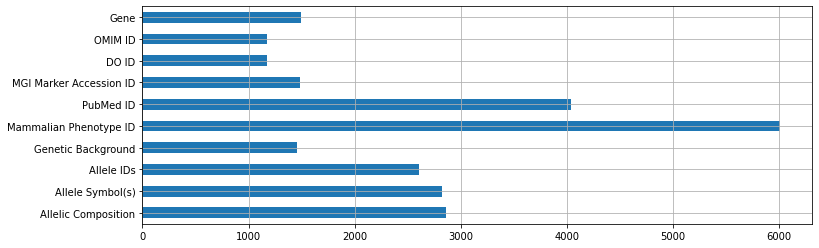

In [28]:
## Table 10.Genotypes with both Phenotype and Disease Annotations for Marker Type Genes, excluding conditional mutations

table10 = 'http://www.informatics.jax.org/downloads/reports/MGI_Geno_DiseaseDO.rpt'

df10 = pd.read_csv(table10,sep='\t')

df10.columns = ['Allelic Composition','Allele Symbol(s)','Allele IDs','Genetic Background','Mammalian Phenotype ID',
              'PubMed ID', 'MGI Marker Accession ID','DO ID','OMIM ID']
print(df10.shape)
df10.head(4)


# Extract gene name from Allele symbol
df10['Gene'] = [ i.split('<')[0] for i in df10['Allele Symbol(s)']]

# See how many unique values we have per column
df10.nunique().plot(kind='barh',grid=True,figsize=(12,4))


print(df10.shape)
df10_dedup = df10[['Mammalian Phenotype ID','Gene']].drop_duplicates(['Mammalian Phenotype ID','Gene'])
df10_dedup.shape


# See overlap in MP terms in Table 10 with Table 5
set(df10['Mammalian Phenotype ID']).issubset(df5['Mammalian Phenotype ID'])

# See overlap in MP terms in Table 10 with Table 5
set(df10['Mammalian Phenotype ID']).issubset(df9['Mammalian Phenotype ID'])

In [29]:
# Both Table 5 and Table 9 MP terms are supersets of Table 10's MP terms, so dont worry about Table 10 right now.

### Lets join the mp term and gene columns together and see if there are any unique mappings in table 9 that arent in table 5 or table 10 or vica-versa 

df5_fused  = df5_dedup['Mammalian Phenotype ID'] +'_'+ df5_dedup['Gene']
print(df5_fused.shape)
print(df5_fused.drop_duplicates().shape);print('-'*10)

df9_fused = df9_dedup['Mammalian Phenotype ID'] +'_'+ df9_dedup['Gene']
print(df9_fused.shape)
print(df9_fused.drop_duplicates().shape);print('-'*10)

df10_fused = df10_dedup['Mammalian Phenotype ID'] +'_'+ df10_dedup['Gene']
print(df10_fused.shape)
print(df10_fused.drop_duplicates().shape)

(278411,)
(278411,)
----------
(201282,)
(201282,)
----------
(30493,)
(30493,)


In [30]:
# Now we have unique gene-phenotype 'mapping strings' for all 3 datasets
df10_fused.head(3)

print(len(df5_fused))
print(len(df9_fused))
print(len(df10_fused))

# if all terms in df9 are in df5 then their intersection should be the length  of df9, which is 194,416
len((set(df5_fused).intersection(set(df9_fused))))

# Unique mp-gene mappings that dont overlap between df5 and df9
194416 - 193126

# if all terms in df9 are in df10 then their intersection should be the length  of df10, which is 30,175
len((set(df5_fused).intersection(set(df10_fused))))

30175 -  29928  # Unique mp-gene mappings that dont overlap between df5 and df10

len((set(df9_fused).intersection(set(df10_fused))))

# 3 way intersection
len(set(df5_fused) & set(df9_fused) & set(df10_fused))

278411
201282
30493


30280

### Create master MGI dataframe

In [31]:
#### Create a master MGI gene-phenotype list

master = pd.concat([df5_dedup,df9_dedup,df10_dedup])

print(master.shape)
master_dedup = master.drop_duplicates()

master_dedup.shape

master_dedup.sample(12)

# Remove rows that contain anything but a single gene in the Gene column  
# For example, some genes look like: Tg(Thy1-MAPT*)1Avil 
# Remove rows if gene contains '(' or ')' or an asterik,

# Tg(Thy1-MAPT*)1Avil = transgene insertion 1, J Avila,  MGI ID: MGI:3813500

m2 = master_dedup[~master_dedup["Gene"].str.contains(pat='\/|\)|\(|\*',regex=True)] # "[^a-zA-Z0-9 -]"
print(len(m2))


#Now look at genes that look like Lta|Lta.  
#Only keep them if genes on either side of '|' are the same

# split up list inTO rows that contain '|' and rows that don't

m2_bar = m2[m2['Gene'].str.contains('\|')]
m2_nobar = m2[~m2['Gene'].str.contains('\|')]



a = [i.split('|') for i in m2_bar['Gene']]

bar_mask = []

for i in a:
    if i[0]==i[1]:
        bar_mask.append(True)
    else:
        bar_mask.append(False)
        
        
# Now we have just the rows where the gene is the same on either side on the bar. 
# I don't want gene values where the genes are different on either side of the bar 
# because I'm not sure what that means in reference to the allele?. Need to go back and check.
m2_bar_fixed = m2_bar[bar_mask]

m2_bar_fixed['Gene'] = [i.split('|')[0] for i in m2_bar_fixed['Gene']]

print(m2_bar_fixed.shape)
m2_bar_fixed.drop_duplicates().shape # No duplicates

# Lets add it back to the master list that did not contain genes with bars
MASTER_LIST_FIXED = pd.concat([m2_nobar,m2_bar_fixed])

# Take a look at genes with non-alhpanumeric characters
non_alphanum = [i for i in MASTER_LIST_FIXED['Gene'] if not i.isalnum()]
np.unique(non_alphanum)

(510186, 2)
241033
(2209, 2)


array(['Ftl2-ps', 'H2-Aa', 'H2-Ab1', 'H2-D1', 'H2-DMa', 'H2-Eb1',
       'H2-Eb2', 'H2-K', 'H2-K1', 'H2-M3', 'H2-M5', 'H2-Oa', 'H2-Ob',
       'H2-Q10', 'H2-T23', 'H2-T24', 'H2-T3', 'Hba-a1', 'Hba-x', 'Hbb-ar',
       'Hbb-b1', 'Hbb-b2', 'Hbb-bh1', 'Hbb-bh2', 'Idd16.1', 'Idd21.1',
       'Idd21.2', 'Idd21.3', 'Idd4.3', 'Idd5.1', 'Idd5.2', 'Idd5.3',
       'Idd5.4', 'Idd6.1', 'Idd6.2', 'Idd6.3', 'Idd9.1', 'Idd9.2',
       'Idd9.3', 'Igh-7', 'Igh-8', 'Igh-J', 'Igh-V', 'Igk-Eik', 'Igk-J',
       'Krtap17-1', 'Krtap8-1', 'M10.17.7Djba', 'M2.8.3Djba',
       'M3.8.6Djba', 'M4.8.4Djba', 'M5.37.5Djba', 'M6.5.3Djba',
       'M6.5.5Djba', 'M6.9.5Djba', 'Mir124a-1hg', 'Mir128-1', 'Mir128-2',
       'Mir133a-1', 'Mir133a-2', 'Mir196a-1', 'Mir196a-2', 'Mir199a-2',
       'Mir1a-1', 'Mir1a-2', 'Mir218-1', 'Mir24-2', 'Mir26a-1', 'Mir7-1',
       'Mir9-2', 'Mir9-3', 'Mir92-1', 'Nkx1-1', 'Nkx2-1', 'Nkx2-2',
       'Nkx2-3', 'Nkx2-5', 'Nkx2-6', 'Nkx2-9', 'Nkx3-1', 'Nkx3-2',
       'Nkx6-1', 'Nkx6-2', '

In [32]:
MASTER_LIST_FIXED.rename(columns= {'Mammalian Phenotype ID' : 'MP_term'},inplace=True)

In [33]:
MASTER_LIST_FIXED.nunique()

MP_term    10392
Gene       17951
dtype: int64

In [34]:
# Create the master genotype-phenotype (gene - phenotype term)
MASTER_G2P = pd.concat([master_impc_filt,MASTER_LIST_FIXED])
print(MASTER_G2P.shape)
MASTER_G2P.head(3)

(271362, 2)


,MP_term,Gene
0,MP:0001312,Gimap3
1,MP:0001697,Prss8
2,MP:0002059,Pstpip2


In [35]:
MASTER_G2P.drop_duplicates(inplace=True)
print(MASTER_G2P.shape)

# Before saving, check for the weird gene entries again (we already did for the MGI master list in MGI.ipynb)
# ie. Tg(Thy1-MAPT*)1Avil, bc we are not including them right now
MASTER_G2P_fixed = MASTER_G2P[~MASTER_G2P["Gene"].str.contains(pat='\/|\)|\(|\*',regex=True)]
MASTER_G2P_fixed.shape

(253280, 2)


(253268, 2)

In [36]:
#MASTER_G2P_fixed.to_csv('mouse_genes2phenotype.csv',index=False)

## Need to add CUIs, CODEs and  CodeIDs
Just recreating the HCOP and MP CUIs and  CodeIDs here?

Add CUIs, CODEs and CodeIDs for mouse genes

In [37]:
MASTER_G2P_fixed['CODE_mouse_gene'] = ['HCOP:'+i for i in MASTER_G2P_fixed['Gene']]
MASTER_G2P_fixed['CodeID_mouse_gene'] = ['HCOP '+i for i in MASTER_G2P_fixed['CODE_mouse_gene']]

#CUI_LEN = 14
#MASTER_G2P_fixed['CUI_mouse_gene']  = ['KC' + str(int(hashlib.sha256(uid.encode('utf8')).hexdigest(),
#                                                      base=16))[:CUI_LEN] for uid in MASTER_G2P_fixed['Gene']]


# THIS  SHOULD ACTUALLY BE CREATED FROM THE CODE ID not the 'Gene', like below
# CUI_mouse_genes = CUIbase64(MASTER_G2P_fixed['Gene'])    

MASTER_G2P_fixed['CUI_mouse_gene'] = CUIbase64(MASTER_G2P_fixed['CodeID_mouse_gene'])

assert MASTER_G2P_fixed['CodeID_mouse_gene'].nunique()  ==  MASTER_G2P_fixed['CUI_mouse_gene'].nunique() 
assert MASTER_G2P_fixed['Gene'].nunique()  ==  MASTER_G2P_fixed['CODE_mouse_gene'].nunique()
assert MASTER_G2P_fixed.isna().sum().sum() == 0

Add CUIs, CODEs and CodeIDs for MP terms

In [38]:
MASTER_G2P_fixed.rename(columns={'MP_term':'CODE_mp_term'},inplace=True)

MASTER_G2P_fixed['CodeID_mp_term'] = ['MP '+i for i in MASTER_G2P_fixed['CODE_mp_term']]

#MASTER_G2P_fixed['CUI_mp_term']  = ['KC' + str(int(hashlib.sha256(uid.encode('utf8')).hexdigest(),
#                                                      base=16))[:CUI_LEN] for uid in MASTER_G2P_fixed['CODE_mp_term']]

MASTER_G2P_fixed['CUI_mp_term'] = CUIbase64(MASTER_G2P_fixed['CodeID_mp_term'])


assert MASTER_G2P_fixed['CodeID_mp_term'].nunique()  ==  MASTER_G2P_fixed['CUI_mp_term'].nunique()
assert MASTER_G2P_fixed['CODE_mp_term'].nunique()  ==  MASTER_G2P_fixed['CodeID_mp_term'].nunique()

### Save CUI-CUI, CODEs and CUI-CODE files.

Save CUIs

In [39]:
# The two columns in the CUI-CUI data frame should be combined into a single CUIs file.
CUIs = pd.DataFrame(MASTER_G2P_fixed['CUI_mouse_gene'].append(
            MASTER_G2P_fixed['CUI_mp_term']).drop_duplicates(),columns=['CUI'])

CUIs.to_pickle(output_dir+'genopheno/CUIs_genotype.pickle')

Save CUI-CUIs

What SAB for CUI-CUI relationships?  - IMPC  
What relationship for gene -- phenotype?  - gene_associated_with_disease and disease_has_associated_gene

In [40]:
# Connect CUIs
CUI_CUI = MASTER_G2P_fixed[['CUI_mouse_gene','CUI_mp_term']].rename(columns={'CUI_mouse_gene':':START_ID',
                                                                             'CUI_mp_term':':END_ID'})

# Add relationship type and  sab to match format of umls CUI-CUI import file
CUI_CUI[':TYPE'] = 'gene_associated_with_phenotype'

# Add inverse relationship (phenotype to gene). Just reverse names of columns,  then concatenate 
CUI_CUI_inverse = MASTER_G2P_fixed[['CUI_mouse_gene','CUI_mp_term']].rename(columns={'CUI_mouse_gene':':END_ID',
                                                                             'CUI_mp_term':':START_ID'})

CUI_CUI_inverse[':TYPE'] = 'phenotype_has_associated_gene'

CUI_CUI_all =  pd.concat([CUI_CUI,CUI_CUI_inverse])

CUI_CUI_all['SAB'] = 'IMPC'

CUI_CUI_all.to_pickle(output_dir+'genopheno/CUI_CUI_genotype.pickle')

Save CODEs

In [41]:
# Create MP Codes and create gene Codes 
# Combine these two files ^^^ to create just one CODEs file. (rename cols and add SAB)
codes_mouse_genes = MASTER_G2P_fixed[['CodeID_mouse_gene','CODE_mouse_gene']]
codes_mp_terms = MASTER_G2P_fixed[['CodeID_mp_term','CODE_mp_term']]
codes_mouse_genes['SAB'] = 'HGNC_HCOP'
codes_mp_terms['SAB']  = 'MP'

CODEs = pd.DataFrame(np.concatenate([codes_mouse_genes.values,codes_mp_terms.values], axis=0),columns=['CodeID',
                      'CODE','SAB'])

CODEs = CODEs[['CodeID','SAB', 'CODE']] # Reorder

CODES = CODEs.drop_duplicates(['CODE','CodeID'])

CODES.to_pickle(output_dir+'genopheno/CODEs_genotype.pickle')

Save CUI-CODEs

In [42]:
# Connect MP Concept to Codes and Connect mouse gene Concepts to CODEs
# Combine these two files ^^^ to create just one CUI-CODEs file. 
code_cui_genes = MASTER_G2P_fixed[['CUI_mouse_gene','CodeID_mouse_gene']]
code_cui_mp = MASTER_G2P_fixed[['CUI_mp_term','CodeID_mp_term']]

CUI_CODEs = pd.DataFrame(np.concatenate([code_cui_genes.values,code_cui_mp.values]),
             columns=['CUI','CODE']).drop_duplicates(['CODE','CUI'])

CUI_CODEs.to_pickle(output_dir+'genopheno/CUI_CODE_genotype.pickle')

### Save whole df so we can check that there are no collisions with these CUIs and CUIs from the other steps

In [9]:
#MASTER_G2P_fixed.to_csv('/Users/stearb/desktop/R03_local/data/UI_check/MASTER_G2P.csv',index=False)

### Extra Code

#### After adding MGI Tables 5, 9 and 10 mappings we increased the number of unique mp terms and genes greatly.
####  Although the number of mp-hp mappings we gain is only 2. Maybe add tables 5,9,10 when we have more complete mp-hp mappings 

In [44]:
print('\n---- IMPC and MGI (Tables 5,9 and 10) data -----')
print(MASTER_G2P_fixed.nunique())
print('\n---- IMPC data only -----')
print(master_impc_filt.nunique())


---- IMPC and MGI (Tables 5,9 and 10) data -----
CODE_mp_term         10297
Gene                 17391
CODE_mouse_gene      17391
CodeID_mouse_gene    17391
CUI_mouse_gene       17391
CodeID_mp_term       10297
CUI_mp_term          10297
dtype: int64

---- IMPC data only -----
MP_term     740
Gene       5966
dtype: int64


### Lets see if we have anymore coverage with Tiffanys mp-hp mappings

In [45]:
len(set(hpo2mp['MPO_URI'].values).intersection(
                                set(MASTER_G2P_fixed['MP_term'].values)))

KeyError: 'MP_term'

In [46]:
hpo2mp['MPO_URI'].unique().shape

(462,)

In [47]:
[i for i in hpo2mp['MPO_URI'].unique() if ':' not in i]

[]

In [101]:
both = []

for i in hpo2mp['MPO_URI'].unique():
    if i in MASTER_G2P_fixed['MP_term'].unique():
        both.append(i)

len(both)

429

Not really...only 2 more

In [117]:
MASTER_G2P_fixed['Gene'].isna().sum()

(234054, 2)

In [ ]:
x=dict(Counter(df['marker_symbol'].values))

allele_freq = {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}

n=16
keys = list(allele_freq.keys())[:n]
values = list(allele_freq.values())[:n]
plt.figure(figsize=(10,4))
plt.bar(keys, values)
plt.xticks(fontsize=15,rotation=40)
plt.grid(alpha=.3)
plt.title('Genes with the most Allele Entries in IMPC')

In [ ]:
#### Use Regex to search for specific phenotype groups so we can see which phenotypes we have
HEART_QUERY = 'heart|cardiac'
KIDNEY_QUERY = 'kidney'
BRAIN_QUERY = 'brain|nervous'
STRUCTURAL_QUERY = 'structural'
CANCER_QUERY = 'cancer|neoplasm|neoplasia'
BONE_QUERY = 'bone'
LUNG_QUERY = 'lung|pulmonary'
DEVELOPMENT_QUERY = 'development|embryo|gestation|fetus|fetal'

heart_mask = pd.DataFrame(overlap['MPO_LABEL']).apply(lambda x: x.str.contains(HEART_QUERY,regex=True,flags=re.IGNORECASE)).any(axis=1)
kidney_mask = pd.DataFrame(overlap['MPO_LABEL']).apply(lambda x: x.str.contains(KIDNEY_QUERY,regex=True,flags=re.IGNORECASE)).any(axis=1)
brain_mask = pd.DataFrame(overlap['MPO_LABEL']).apply(lambda x: x.str.contains(BRAIN_QUERY,regex=True,flags=re.IGNORECASE)).any(axis=1)
struct_mask = pd.DataFrame(overlap['MPO_LABEL']).apply(lambda x: x.str.contains(STRUCTURAL_QUERY,regex=True,flags=re.IGNORECASE)).any(axis=1)
cancer_mask = pd.DataFrame(overlap['MPO_LABEL']).apply(lambda x: x.str.contains(CANCER_QUERY,regex=True,flags=re.IGNORECASE)).any(axis=1)
bone_mask = pd.DataFrame(overlap['MPO_LABEL']).apply(lambda x: x.str.contains(BONE_QUERY,regex=True,flags=re.IGNORECASE)).any(axis=1)
lung_mask = pd.DataFrame(overlap['MPO_LABEL']).apply(lambda x: x.str.contains(LUNG_QUERY,regex=True,flags=re.IGNORECASE)).any(axis=1)
dev_mask =  pd.DataFrame(overlap['MPO_LABEL']).apply(lambda x: x.str.contains(DEVELOPMENT_QUERY,regex=True,flags=re.IGNORECASE)).any(axis=1)

#list(overlap['MPO_LABEL'][heart_mask])
#list(overlap['MPO_LABEL'][kidney_mask])
#list(overlap['MPO_LABEL'][brain_mask])

